# TSFRESH Robot Failure Example
This example show shows how to use [tsfresh](https://tsfresh.readthedocs.io/) to exctract useful features from multiple timeseries and use them to improve classification performance.

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report

/Users/mchrist/Documents/Research/tsfresh/venv/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/Users/mchrist/Documents/Research/tsfresh/venv/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/mchrist/Documents/Research/tsfresh/venv/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This mo

## Load and visualize data
The data consists of timeseries for 88 robots (`id` 1 - 88).  For each robot, each timepoint (`time`) contains datapoints from 6 sensors (`a` - `f`) leading up to a success or failure (`y`).

In [2]:
download_robot_execution_failures()
df, y = load_robot_execution_failures()
df.head()

,id,time,a,b,c,d,e,f
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0


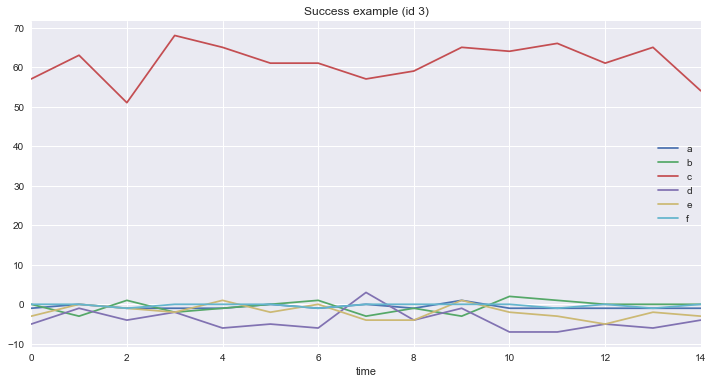

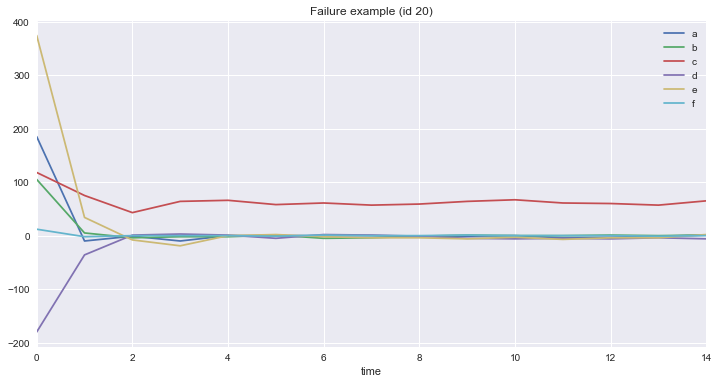

In [3]:
df[df.id == 3][['time', 'a', 'b', 'c', 'd', 'e', 'f']].plot(x='time', title='Success example (id 3)', figsize=(12, 6));
df[df.id == 20][['time', 'a', 'b', 'c', 'd', 'e', 'f']].plot(x='time', title='Failure example (id 20)', figsize=(12, 6));

## Extract Features

In [4]:
extraction_settings = ComprehensiveFCParameters()

In [5]:
X = extract_features(df, 
                     column_id='id', column_sort='time',
                     default_fc_parameters=extraction_settings,
                     impute_function= impute)

Feature Extraction: 100%|██████████| 6/6 [00:17<00:00,  2.84s/it]
 'b__spkt_welch_density__coeff_8' 'e__spkt_welch_density__coeff_8'
 'd__spkt_welch_density__coeff_8' 'f__spkt_welch_density__coeff_8'] did not have any finite values. Filling with zeros.


In [6]:
X.head()

,a__mean_abs_change_quantiles__qh_1.0__ql_0.8,a__percentage_of_reoccurring_values_to_all_values,a__mean_abs_change_quantiles__qh_1.0__ql_0.2,a__mean_abs_change_quantiles__qh_1.0__ql_0.0,a__large_standard_deviation__r_0.45,a__absolute_sum_of_changes,a__mean_abs_change_quantiles__qh_1.0__ql_0.4,a__mean_second_derivate_central,a__autocorrelation__lag_4,a__binned_entropy__max_bins_10,...,f__fft_coefficient__coeff_0,f__fft_coefficient__coeff_1,f__fft_coefficient__coeff_2,f__fft_coefficient__coeff_3,f__fft_coefficient__coeff_4,f__fft_coefficient__coeff_5,f__fft_coefficient__coeff_6,f__fft_coefficient__coeff_7,f__fft_coefficient__coeff_8,f__fft_coefficient__coeff_9
id,,,,,,,,,,,,,,,,,,,,,
1,0.142857,0.933333,0.142857,0.142857,0.0,2.0,0.142857,-0.038462,0.17553,0.244930,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
2,0.000000,1.000000,0.400000,1.000000,0.0,14.0,0.400000,-0.038462,0.17553,0.990835,...,-4.0,0.744415,1.273659,-0.809017,1.373619,0.5,0.309017,-1.391693,0.0,0.0
3,0.000000,0.933333,0.714286,0.714286,0.0,10.0,0.714286,-0.038462,0.17553,0.729871,...,-4.0,-0.424716,0.878188,1.000000,1.851767,0.5,1.000000,-2.805239,0.0,0.0
4,0.000000,1.000000,0.800000,1.214286,0.0,17.0,0.800000,-0.038462,0.17553,1.322950,...,-5.0,-1.078108,3.678858,-3.618034,-1.466977,-0.5,-1.381966,-0.633773,0.0,0.0
5,2.000000,0.866667,0.916667,0.928571,0.0,13.0,0.916667,0.038462,0.17553,1.020037,...,-2.0,-3.743460,3.049653,-0.618034,1.198375,-0.5,1.618034,-0.004568,0.0,0.0


In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 1 to 88
Columns: 1332 entries, a__mean_abs_change_quantiles__qh_1.0__ql_0.8 to f__fft_coefficient__coeff_9
dtypes: float64(1332)
memory usage: 916.4 KB


In [8]:
X_filtered = extract_relevant_features(df, y, 
                                       column_id='id', column_sort='time', 
                                       default_fc_parameters=extraction_settings)

Feature Extraction: 100%|██████████| 6/6 [00:14<00:00,  2.43s/it]
 'b__spkt_welch_density__coeff_8' 'e__spkt_welch_density__coeff_8'
 'd__spkt_welch_density__coeff_8' 'f__spkt_welch_density__coeff_8'] did not have any finite values. Filling with zeros.


In [9]:
X_filtered.head()

,a__abs_energy,a__range_count__max_1__min_-1,b__abs_energy,e__variance,e__standard_deviation,e__abs_energy,c__standard_deviation,c__variance,a__standard_deviation,a__variance,...,b__has_duplicate_max,"b__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_14__w_5","b__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_13__w_2",e__quantile__q_0.1,a__ar_coefficient__k_10__coeff_1,a__quantile__q_0.2,b__quantile__q_0.7,f__large_standard_deviation__r_0.35,f__quantile__q_0.9,d__spkt_welch_density__coeff_5
id,,,,,,,,,,,,,,,,,,,,,
1,14.0,15.0,13.0,0.222222,0.471405,10.0,1.203698,1.448889,0.249444,0.062222,...,1.0,-0.751682,-0.310265,-1.0,0.125000,-1.0,-1.0,0.0,0.0,0.037795
2,25.0,13.0,76.0,4.222222,2.054805,90.0,4.333846,18.782222,0.956847,0.915556,...,1.0,0.057818,-0.202951,-3.6,-0.078829,-1.0,-1.0,1.0,0.0,0.319311
3,12.0,14.0,40.0,3.128889,1.768867,103.0,4.616877,21.315556,0.596285,0.355556,...,0.0,0.912474,0.539121,-4.0,0.084836,-1.0,0.0,1.0,0.0,9.102780
4,16.0,10.0,60.0,7.128889,2.669998,124.0,3.833188,14.693333,0.952190,0.906667,...,0.0,-0.609735,-2.641390,-4.6,0.003108,-1.0,1.0,0.0,0.0,56.910262
5,17.0,13.0,46.0,4.160000,2.039608,180.0,4.841487,23.440000,0.879394,0.773333,...,0.0,0.072771,0.591927,-5.0,0.087906,-1.0,0.8,0.0,0.6,22.841805


In [10]:
X_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 1 to 88
Columns: 300 entries, a__abs_energy to d__spkt_welch_density__coeff_5
dtypes: float64(300)
memory usage: 206.9 KB


## Train and evaluate classifier

In [11]:
X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)

In [12]:
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

             precision    recall  f1-score   support

          0       1.00      0.89      0.94         9
          1       0.96      1.00      0.98        27

avg / total       0.97      0.97      0.97        36



In [13]:
cl.n_features_

1332

In [14]:
cl2 = DecisionTreeClassifier()
cl2.fit(X_filtered_train, y_train)
print(classification_report(y_test, cl2.predict(X_filtered_test)))

             precision    recall  f1-score   support

          0       1.00      0.78      0.88         9
          1       0.93      1.00      0.96        27

avg / total       0.95      0.94      0.94        36



In [15]:
cl2.n_features_

300

Compared to using all (1236) features, using only the (283) relevant features achieves better classification performance with less data.

# Extraction + filtering is the same as filtered extraction

Above, we performed two feature extractions runs. A filtered one and a non filtered one. However, the results of the filtered is equal to just extracting all features and then filtering them.

In [16]:
X_filtered_2 = select_features(X, y)

In [17]:
(X_filtered.columns == X_filtered_2.columns).all()

True